In [22]:
from io import open

import glob

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os

import random

import string

import time

import torch
import torch.nn as nn

import unicodedata

In [23]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [24]:
all_letters = string.ascii_letters + " .,;'"

In [25]:
n_letters = len(all_letters)

In [26]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [27]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [28]:
print(category_lines['Italian'][300:306])

["D'onofrio", 'Drago', 'Durante', 'Elena', 'Episcopo', 'Ermacora']


In [29]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [30]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [31]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [32]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [33]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [34]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9636, -2.9104, -2.9114, -2.9256, -2.8178, -2.9206, -2.8117, -2.9373,
         -2.9146, -2.8353, -2.8401, -2.9141, -2.8521, -2.9387, -2.9144, -2.9477,
         -2.8086, -2.8844]], grad_fn=<LogSoftmaxBackward0>)


In [35]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [36]:
print(categoryFromOutput(output))

('Spanish', 16)


In [37]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Nader
category = English / line = Hawley
category = German / line = Mohren
category = English / line = Golding
category = Portuguese / line = Mateus
category = Irish / line = Pharlain
category = Portuguese / line = Nunes
category = Italian / line = Barzetti
category = English / line = Roffey
category = Chinese / line = Dong


In [38]:
criterion = nn.NLLLoss()

In [39]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [40]:
n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.9248 Lange / French ✗ (German)
10000 10% (0m 9s) 0.5969 Napoleoni / Italian ✓
15000 15% (0m 13s) 2.9000 Cooper / German ✗ (English)
20000 20% (0m 18s) 2.6913 Kava / Japanese ✗ (Polish)
25000 25% (0m 22s) 1.3992 Choshi / Arabic ✗ (Japanese)
30000 30% (0m 27s) 2.6613 Atiyeh / Russian ✗ (Arabic)
35000 35% (0m 31s) 1.7526 Vargas / French ✗ (Portuguese)
40000 40% (0m 36s) 1.8853 Nayler / German ✗ (English)
45000 45% (0m 40s) 3.7521 Kaluza / Arabic ✗ (Polish)
50000 50% (0m 45s) 0.7130 Reynders / Dutch ✓
55000 55% (0m 50s) 1.1643 Cassano / Portuguese ✗ (Italian)
60000 60% (0m 54s) 0.3690 Pesek / Czech ✓
65000 65% (0m 59s) 1.3645 Ho / Korean ✗ (Vietnamese)
70000 70% (1m 4s) 1.4708 Ojeda / Japanese ✗ (Spanish)
75000 75% (1m 8s) 0.6278 Zunino / Italian ✓
80000 80% (1m 13s) 4.3156 Canne / French ✗ (Dutch)
85000 85% (1m 17s) 0.5651 Kim / Korean ✓
90000 90% (1m 22s) 0.7646 Ritchie / Scottish ✓
95000 95% (1m 26s) 0.1417 Nghiem / Vietnamese ✓
100000 100% (1m 31s) 2.8853 Leandres / P

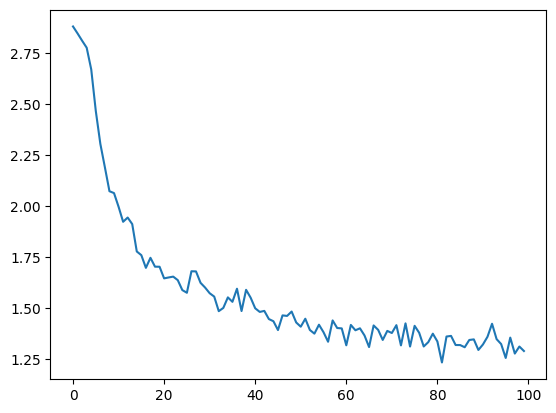

In [41]:
plt.figure()
plt.plot(all_losses)

C:\Users\layor\AppData\Local\Temp\ipykernel_21676\3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\layor\AppData\Local\Temp\ipykernel_21676\3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


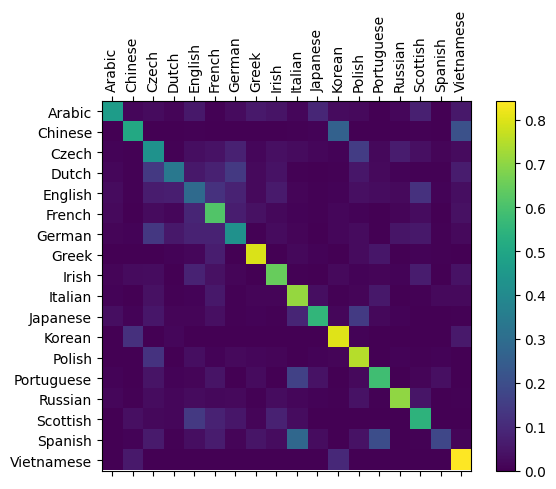

In [42]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [44]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [51]:
predict('Zamek')
predict('Jackson')
predict('Satoshi')


> Zamek
(-0.44) Polish
(-1.19) Czech
(-4.09) Russian

> Jackson
(-1.09) English
(-1.64) Russian
(-1.90) Scottish

> Satoshi
(-1.05) Japanese
(-1.51) Italian
(-1.80) Polish


In [47]:
predict("Ayanami")
predict("Kowalski")
predict("Dostoevsky")


> Ayanami
(-0.16) Japanese
(-2.75) Italian
(-3.06) Arabic

> Kowalski
(-0.02) Polish
(-4.43) Russian
(-5.11) Czech

> Dostoevsky
(-0.11) Russian
(-2.45) Czech
(-4.44) English
